In [17]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout # Import layers directly
from tensorflow.keras.models import Model, Sequential # Import Sequential directly
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt

from google.colab import drive

In [18]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Navigate to your folder (replace with your actual folder path)
folder_path = '/content/drive/My Drive/split_dataset'

# List files in the folder
os.listdir(folder_path)

['images', 'split_dataset', 'labels', '__MACOSX']

In [20]:
def load_image_and_label(image_path, label_path, image_size=(224, 224)):
    # Remove .numpy() as it's already a Python bytes object
    image_path = image_path.decode('utf-8')
    label_path = label_path.decode('utf-8')

    image_size_int = (int(image_size[0]), int(image_size[1]))

    # Load and resize image
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size_int)

    # Median filter for noise reduction
    img = cv2.medianBlur(img, 5)
    img = img.astype(np.float32) / 255.0  # Normalize

    # Convert to HSV and extract V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]

    # Apply high-pass filter on V channel
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])
    high_pass = cv2.filter2D(v_channel, -1, kernel)
    high_pass = high_pass.astype(np.float32) / 255.0

    # Read class ID from label file
    with open(label_path, 'r') as file:
        line = file.readline().strip()
        class_id = int(line.split()[0]) if line else 0

    # One-hot encode the class ID
    label_vector = np.zeros(num_classes, dtype=np.float32)
    label_vector[class_id] = 1.0

    return high_pass[..., np.newaxis], label_vector

In [21]:
def tf_load_image_and_label(img_path, lbl_path, image_size):
    def _load(img_path_np, lbl_path_np):
        return load_image_and_label(img_path_np, lbl_path_np, image_size)

    img, label = tf.numpy_function(
        _load, [img_path, lbl_path], [tf.float32, tf.float32]
    )
    img.set_shape((image_size[0], image_size[1], 1))
    label.set_shape((num_classes,))
    return img, label

In [22]:
def create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train', show_warnings=True):
    sub_image_dir = os.path.join(image_dir, dataset_type)
    sub_label_dir = os.path.join(label_dir, dataset_type)

    image_paths = [f for f in os.listdir(sub_image_dir) if f.endswith(('.jpg', '.png'))]

    image_file_paths = []
    label_file_paths = []

    for image_name in image_paths:
        base_name = os.path.splitext(image_name)[0]
        label_name = base_name + '.txt'
        label_path = os.path.join(sub_label_dir, label_name)

        if os.path.exists(label_path):
            image_file_paths.append(os.path.join(sub_image_dir, image_name))
            label_file_paths.append(label_path)
        else:
            if show_warnings:
                print(f"Warning: Missing label file for image: {image_name}")

    if not image_file_paths:
        if show_warnings:
            print(f"Warning: No valid image-label pairs found in {sub_image_dir}")
        return tf.data.Dataset.from_tensor_slices(())


    # Convert paths to TensorFlow string tensors
    image_file_paths_tf = tf.constant(image_file_paths)
    label_file_paths_tf = tf.constant(label_file_paths)

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths_tf, label_file_paths_tf))
    dataset = dataset.map(
        lambda img_path, lbl_path: tf_load_image_and_label(img_path, lbl_path, image_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if dataset_type == 'train':
        # Use tf.data.experimental.cardinality for shuffle buffer size if possible
        cardinality = tf.data.experimental.cardinality(dataset).numpy()
        if cardinality != tf.data.experimental.INFINITE_CARDINALITY and cardinality != tf.data.experimental.UNKNOWN_CARDINALITY:
             shuffle_buffer_size = cardinality
        else:
             # Fallback if cardinality is unknown or infinite
             shuffle_buffer_size = min(len(image_file_paths), 1000) # Use a reasonable buffer size
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [23]:
num_classes = 2

# Use Sequential directly
model = Sequential([
    Input(shape=(224, 224, 1)), # Use Input directly
    Conv2D(32, (3, 3), activation='relu'), # Use Conv2D directly
    MaxPooling2D((2, 2)), # Use MaxPooling2D directly
    Conv2D(64, (3, 3), activation='relu'), # Use Conv2D directly
    MaxPooling2D((2, 2)), # Use MaxPooling2D directly
    Conv2D(128, (3, 3), activation='relu'), # Use Conv2D directly
    MaxPooling2D((2, 2)), # Use MaxPooling2D directly
    Flatten(), # Use Flatten directly
    Dense(128, activation='relu'), # Use Dense directly
    Dropout(0.5), # Use Dropout directly
    Dense(num_classes, activation='softmax') # Use Dense directly
])

In [24]:
image_dir = '/content/drive/My Drive/split_dataset/images'
label_dir = '/content/drive/My Drive/split_dataset/labels'

train_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train')
val_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='val')
test_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='test')

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check if datasets are empty before fitting
if train_dataset is not None and tf.data.experimental.cardinality(train_dataset).numpy() > 0:
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1514s 7s/step - accuracy: 0.5170 - loss: 0.7012 - val_accuracy: 0.5726 - val_loss: 0.6834
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step - accuracy: 0.5149 - loss: 0.6954 - val_accuracy: 0.5726 - val_loss: 0.6905
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 292ms/step - accuracy: 0.5033 - loss: 0.6935 - val_accuracy: 0.5726 - val_loss: 0.6886
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 167ms/step - accuracy: 0.5014 - loss: 0.6936 - val_accuracy: 0.5726 - val_loss: 0.6887
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.5201 - loss: 0.6917 - val_accuracy: 0.5726 - val_loss: 0.6895
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 291ms/step - accuracy: 0.5056 - loss: 0.6933 - val_accuracy: 0.5726 - val_loss: 0.6909
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.5115 - loss: 0.6929 - val_accuracy: 0.5726 - val_loss: 0.6897
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accuracy: 0.5532 - loss: 0.6910 - val_accur

In [28]:
# Access loss and accuracy history
train_loss = history.history['loss']  # List of training loss values per epoch
train_accuracy = history.history['accuracy']  # List of training accuracy values per epoch
val_loss = history.history['val_loss']  # List of validation loss values per epoch
val_accuracy = history.history['val_accuracy']  # List of validation accuracy values per epoch

# Print the final values of loss and accuracy for the last epoch
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Final Training Loss: 0.692528486251831
Final Training Accuracy: 0.5184072256088257
Final Validation Loss: 0.6891336441040039
Final Validation Accuracy: 0.5726495981216431


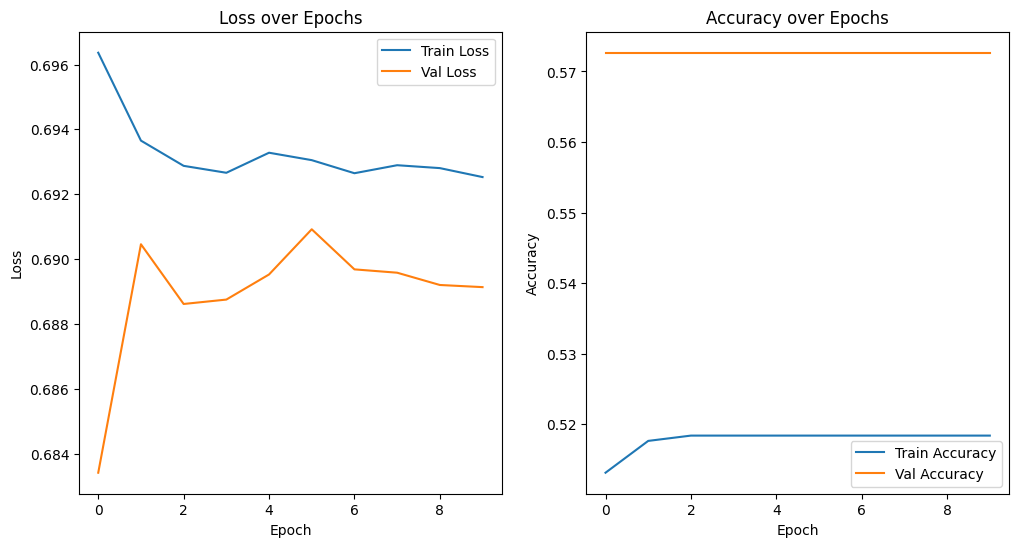

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [30]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 205s 25s/step - accuracy: 0.5312 - loss: 0.6917
Test Loss: 0.6931052803993225
Test Accuracy: 0.5084033608436584
